In [1]:
import os
import numpy as np
import csv
import random
import time
import pickle
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
wordnet_mammal_file = 'data/wordnet_mammal_hypernyms.tsv'

In [3]:
def load_wordnetload_wor (wordnet_path):
    network = {}
    with open(wordnet_path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            if not row[0]==row[1]:
                if row[0] in network:
                    network[row[0]].append(row[1])
                else:
                    network.update({row[0]:[row[1]]})
    return network

In [4]:
network = load_wordnetload_wor(wordnet_mammal_file)
network

{'kangaroo.n.01': ['marsupial.n.01', 'mammal.n.01', 'metatherian.n.01'],
 'domestic_goat.n.01': ['even-toed_ungulate.n.01',
  'ruminant.n.01',
  'goat.n.01',
  'placental.n.01',
  'bovid.n.01',
  'ungulate.n.01',
  'mammal.n.01'],
 'rock_squirrel.n.01': ['ground_squirrel.n.02',
  'squirrel.n.01',
  'rodent.n.01',
  'mammal.n.01',
  'placental.n.01'],
 'vizsla.n.01': ['dog.n.01',
  'placental.n.01',
  'sporting_dog.n.01',
  'mammal.n.01',
  'carnivore.n.01',
  'canine.n.02',
  'pointer.n.04',
  'hunting_dog.n.01'],
 'dandie_dinmont.n.01': ['mammal.n.01',
  'terrier.n.01',
  'dog.n.01',
  'hunting_dog.n.01',
  'canine.n.02',
  'placental.n.01',
  'carnivore.n.01'],
 'broodmare.n.01': ['horse.n.01',
  'ungulate.n.01',
  'odd-toed_ungulate.n.01',
  'placental.n.01',
  'mare.n.01',
  'mammal.n.01',
  'equine.n.01'],
 'lesser_kudu.n.01': ['placental.n.01',
  'kudu.n.01',
  'even-toed_ungulate.n.01',
  'mammal.n.01',
  'antelope.n.01',
  'bovid.n.01',
  'ruminant.n.01',
  'ungulate.n.01'],
 '

In [5]:
def dist(u, v): 
    """Distance de Poincaré (équation 1 de l'article)"""
    return 1 + 2*np.dot(u - v, u - v)/ \
             ((1-np.dot(u, u))*(1-np.dot(v, v)) + EPSILON)

In [6]:
def partial_der(theta, x, gamma): 
    """Dérivée partielle par rapport à theta (equation 4 de l'article)"""
    alpha = (1.0-np.dot(theta, theta))
    norm_x = np.dot(x, x)
    beta = (1-norm_x)
    gamma = gamma
    return 4.0/(beta * np.sqrt(gamma*gamma - 1) + EPSILON)*((norm_x- 2*np.dot(theta, x)+1)/(pow(alpha,2)+EPSILON)*theta - x/(alpha + EPSILON))

In [7]:
def update(emb, error_, lr):
    """Equation d'update (equation 5)"""
    try:
        update =  lr*pow((1 - np.dot(emb,emb)), 2)*error_/4
        emb = emb - update
        if (np.dot(emb, emb) >= 1):
            emb = emb/sqrt(np.dot(emb, emb)) - EPSILON
        return emb
    except Exception as e:
        print (e)

In [8]:
#connaître les n noeuds les plus proches d'un autre noeud
def distance_min(node, n):
    #distance de chaque noeud au noeud node
    distance_to_node = np.zeros(len(vocab))
    #index des mots ayant la plus petite distance aux mots node
    index_minimum = np.zeros(n)
    for i in range(len(vocab)):
        distance_to_node[i] = dist(emb[node],emb[vocab[i]])
    index_minimum = np.argpartition(distance_to_node, n)
    for i in range(n):
        print(vocab[index_minimum[i]])

In [9]:
def get_vocabulary(network):
    vocab = list(emb.keys())
    vocab_weights = np.zeros(len(vocab))
    for key in network:
        for u in network[key]:
            vocab_weights[vocab.index(u)]+=1
    vocab_weights = vocab_weights / np.sum(vocab_weights)
    return vocab, vocab_weights

In [10]:
def initialize_embedding(network, embedding_size):
    """Comme dans l'article, on initialise la position des noeuds entre 0.001 et -0.001"""
    emb = {}
    gap = 1e-3
    for a in network:
        for b in network[a]:
            emb[b] = np.random.uniform(low=-gap, high=gap, size=(embedding_size,))
        emb[a] = np.random.uniform(low=-gap, high=gap, size=(embedding_size,))
    return emb

In [11]:
def get_negative_candidates(network, vocab, vocab_weights, u, num_negs):
    """Retourne une liste de mots qui ne sont pas liés à celui donné en entrée"""
    negs = []
    i = 0
    while (len(negs) < num_negs):
        neg = np.random.choice(vocab, p=vocab_weights)
        #neg = vocab[np.searchsorted(vocab_weights.cumsum(), random.random())]
        if not (neg in network[u] or u in network[neg] or neg == u): # neg ne doit pas etre lié à u et vice versa
            #or neg in negs
            negs.append(neg)
    return negs

In [12]:
def euclidian_dist(u,v):
    """Distance euclidienne"""
    return np.dot(u-v,u-v)

In [13]:
def poincare_dist(gamma): 
    """Distance de Poincaré (équation 1 de l'article)"""
    return np.arccosh(gamma)

In [14]:
def compute_gamma(vec1, vec2):
    euclidean_dists = np.linalg.norm(vec1 - vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    alpha = 1-norm1**2
    beta = 1-norm2**2
    gamma = 1 + 2*euclidean_dists/(alpha*beta)
    return gamma

In [15]:
def deriv_poincare_theta(theta, x, gamma): 
    """Dérivée partielle par rapport à theta de la distance de Poincare (equation 4 de l'article)"""
    alpha = (1.0-np.dot(theta, theta))
    norm_x = np.dot(x, x)
    beta = (1-norm_x)
    gamma = gamma
    return 4.0/(beta * np.sqrt(gamma*gamma - 1))*((norm_x- 2*np.dot(theta, x)+1)/(pow(alpha,2))*theta - x/(alpha))

In [16]:
def plot_poincare_embeddings(emb, epochs, nb_burn_in, num_negs, save=True, show=False):
    fig=plt.figure(figsize=(15,15))
    names = []
    positions_x = []
    positions_y = []
    for key in emb:
        names.append(key)
        positions_x.append(emb[key][0])
        positions_y.append(emb[key][1])

    plt.scatter(positions_x,positions_y, s=1)
    k=1
    plt.text(positions_x[k], positions_y[k], names[k] + " " + str(positions_x[k]), fontsize=10)

    circle = plt.Circle((0, 0), 1, color='g',fill=False)

    plt.axis([-1,1,-1,1])
    ax=fig.add_subplot(1,1,1)
    ax.add_patch(circle)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.title("Poincaré embeddings pour " + str(epochs - nb_burn_in) + " epochs, "
              + str(num_negs) + " negatifs, " 
             + str(nb_burn_in) + " périodes de burn-in")

    if save:
        plt.savefig('data/poincaré_embeddings_epochs_' + str(epochs - nb_burn_in) + '.png')
    
    if show:
        plt.show()

In [17]:
#Initialisation des variables

embedding_size = 50 #dimension des vecteurs d'entrainement
emb = initialize_embedding(network, embedding_size)# embedding of nodes of network

#epochs
num_epochs = 1000

#burn-in, nombre d'épochs
nb_burn_in = 10

#nombre de nodes negatives pour l'entrainement
num_negs = 20

#learning rate
lr = 1e-2

#learning rate pour le burn-in
learning_rate_burn_in = 0.001

EPSILON = 0.00001 # evite l'overflow

vocab, vocab_weights = get_vocabulary(network)

In [18]:
# Randomly uniform distribution
for a in network:
    for b in network[a]:
        emb[b] = np.random.uniform(low=-0.001, high=0.001, size=(embedding_size,))
    emb[a] = np.random.uniform(low=-0.001, high=0.001, size=(embedding_size,))

vocab = list(emb.keys())

In [19]:
# #on supprime l'origine de la liste du vocabulaire, car il est lié à tous les mots
# index_origin = vocab.index("mammal.n.01")

# del vocab[index_origin]
# vocab_weights = np.delete(vocab_weights, index_origin)

# vocab_weights = vocab_weights/sum(vocab_weights)

In [20]:
#random.shuffle(vocab)

# the leave nodes are not connected to anything
for a in emb:
    if not a in network:
        network[a] = []

last_time = time.time()
loss_stock = np.zeros(num_epochs+nb_burn_in)
for epoch in range(num_epochs+nb_burn_in):
    loss_total = 0
    if epoch < nb_burn_in:
        burn_in = True
    else:
        burn_in = False
    for u in vocab:
        if not network[u]: # une node
            continue
        v = random.choice(network[u]) # u et v sont liés
        euclidian_dist_u_v = euclidian_dist(emb[u], emb[v])
        gamma_u_v = compute_gamma(emb[u], emb[v])
        dist_p_u_v = poincare_dist(gamma_u_v) # distance between the related nodes
        
        negs = [] # pairs of not related nodes, the first node in the pair is `pos1`
        gamma_u_negs = [] # distances entre nodes qui ne sont pas liées
        dist_negs = [] # distances entre nodes qui ne sont pas liées
        negs = get_negative_candidates(network, vocab, vocab_weights, u, num_negs) 
        for neg in negs:
            gamma_u_neg = compute_gamma(emb[u], emb[neg])
            gamma_u_negs.append(gamma_u_neg)
            dist_neg = poincare_dist(gamma_u_neg)
            dist_negs.append(dist_neg)
                
        loss_den = 0.0
        
        # eqn6
        for dist_neg in dist_negs:
            loss_den += np.exp(-1*dist_neg)
        loss = -1*dist_p_u_v - np.log(loss_den)
        #loss_euclidian = -1*euclidian_dist_u_v - np.log(loss_den)
        loss_total = loss_total + loss
        
        # derivative of loss wrt positive relation [d(u, v)]
        der_p = -1
        der_negs = []
        # derivative of loss wrt negative relation [d(u, v')]
        for dist_neg in dist_negs:
            der_negs.append(np.exp(-1*dist_neg)/(loss_den))
        # derivative of loss wrt pos1
        der_p_u = der_p * deriv_poincare_theta(emb[u], emb[v], gamma_u_v)
        # derivative of loss wrt pos2
        der_p_v = der_p * deriv_poincare_theta(emb[v], emb[u], gamma_u_v)
        
        der_negs_final = []        
        for (der_neg, neg, gamma_u_neg) in list(zip(der_negs, negs, gamma_u_negs)):
            # derivative of loss wrt second element of the pair in neg
            der_neg1 = der_neg * deriv_poincare_theta(emb[neg], emb[u], gamma_u_neg)
            # derivative of loss wrt first element of the pair in neg
            der_neg0 = der_neg * deriv_poincare_theta(emb[u], emb[neg], gamma_u_neg)
            der_negs_final.append([der_neg0, der_neg1])
        
        # update embeddings now
        if burn_in:
            emb[u] = update(emb[u], -1*der_p_u, learning_rate_burn_in)
            emb[v] = update(emb[v], -1*der_p_v, learning_rate_burn_in)  
        else:
            emb[u] = update(emb[u], -1*der_p_u, lr)
            emb[v] = update(emb[v], -1*der_p_v, lr)
        for (neg, der_neg) in list(zip(negs, der_negs_final)):
            if burn_in:
                emb[u] = update(emb[u], -1*der_neg[0], learning_rate_burn_in)
                emb[neg] = update(emb[neg], -1*der_neg[1], learning_rate_burn_in)
            else:
                emb[u] = update(emb[u], -1*der_neg[0], lr)
                emb[neg] = update(emb[neg], -1*der_neg[1], lr) 
    print(loss_total)
    loss_stock[epoch] = loss_total
    
    if((epoch-nb_burn_in)%50 == 0 and embedding_size == 2):
        plot_poincare_embeddings(emb, epoch, nb_burn_in, num_negs, save=True, show=False)            
    print('Epoch #%d, temps d\'exécution: %.2f seconds' % (epoch + 1, time.time() - last_time))
    last_time = time.time()
#pickle.dump(emb, open('data/train.pickle', 'wb'))

-3530.71684796
Epoch #1, temps d'exécution: 5.98 seconds
-3526.02951732
Epoch #2, temps d'exécution: 6.09 seconds
-3524.1150508
Epoch #3, temps d'exécution: 6.02 seconds
-3522.69934602
Epoch #4, temps d'exécution: 6.02 seconds
-3521.61568217
Epoch #5, temps d'exécution: 6.00 seconds
-3519.09288303
Epoch #6, temps d'exécution: 6.03 seconds
-3517.06199776
Epoch #7, temps d'exécution: 6.03 seconds
-3517.99707086
Epoch #8, temps d'exécution: 6.05 seconds
-3516.68508236
Epoch #9, temps d'exécution: 6.03 seconds
-3516.98257762
Epoch #10, temps d'exécution: 5.96 seconds
-3505.37043678
Epoch #11, temps d'exécution: 5.97 seconds
-3491.40053484
Epoch #12, temps d'exécution: 5.95 seconds
-3474.74719557
Epoch #13, temps d'exécution: 5.97 seconds
-3468.34877489
Epoch #14, temps d'exécution: 6.00 seconds
-3446.79929336
Epoch #15, temps d'exécution: 5.93 seconds
-3436.141688
Epoch #16, temps d'exécution: 5.99 seconds
-3435.98042515
Epoch #17, temps d'exécution: 5.97 seconds
-3418.38800893
Epoch #18, 

-2503.51006733
Epoch #143, temps d'exécution: 6.00 seconds
-2487.2064648
Epoch #144, temps d'exécution: 5.96 seconds
-2542.68141186
Epoch #145, temps d'exécution: 5.99 seconds
-2571.68576467
Epoch #146, temps d'exécution: 5.96 seconds
-2540.30271151
Epoch #147, temps d'exécution: 5.96 seconds
-2507.90481383
Epoch #148, temps d'exécution: 6.04 seconds
-2478.93659963
Epoch #149, temps d'exécution: 5.98 seconds
-2443.62998228
Epoch #150, temps d'exécution: 5.95 seconds
-2495.80933589
Epoch #151, temps d'exécution: 6.00 seconds
-2420.9273972
Epoch #152, temps d'exécution: 5.98 seconds
-2418.54355307
Epoch #153, temps d'exécution: 6.01 seconds
-2409.35992374
Epoch #154, temps d'exécution: 5.97 seconds
-2347.82576065
Epoch #155, temps d'exécution: 5.97 seconds
-2450.31987085
Epoch #156, temps d'exécution: 6.02 seconds
-2389.83968285
Epoch #157, temps d'exécution: 5.99 seconds
-2348.57471303
Epoch #158, temps d'exécution: 5.91 seconds
-2363.07360553
Epoch #159, temps d'exécution: 5.98 seconds

-467.34527912
Epoch #283, temps d'exécution: 5.92 seconds
-574.232210172
Epoch #284, temps d'exécution: 6.00 seconds
-564.286985758
Epoch #285, temps d'exécution: 5.98 seconds
-691.336272456
Epoch #286, temps d'exécution: 6.03 seconds
-654.505620382
Epoch #287, temps d'exécution: 5.97 seconds
-661.690507989
Epoch #288, temps d'exécution: 5.99 seconds
-433.016887449
Epoch #289, temps d'exécution: 5.99 seconds
-685.804689144
Epoch #290, temps d'exécution: 6.01 seconds
-554.392901246
Epoch #291, temps d'exécution: 5.98 seconds
-269.709703959
Epoch #292, temps d'exécution: 6.00 seconds
-440.496463619
Epoch #293, temps d'exécution: 5.97 seconds
-299.495467115
Epoch #294, temps d'exécution: 6.00 seconds
-447.968634733
Epoch #295, temps d'exécution: 6.03 seconds
-284.196472979
Epoch #296, temps d'exécution: 5.99 seconds
-476.458201419
Epoch #297, temps d'exécution: 6.00 seconds
-315.133572568
Epoch #298, temps d'exécution: 5.94 seconds
-274.571730938
Epoch #299, temps d'exécution: 5.96 second

2316.05203444
Epoch #425, temps d'exécution: 5.97 seconds
2225.65159781
Epoch #426, temps d'exécution: 6.03 seconds
2090.07170352
Epoch #427, temps d'exécution: 5.98 seconds
2091.90959348
Epoch #428, temps d'exécution: 5.99 seconds
1952.83473667
Epoch #429, temps d'exécution: 6.02 seconds
2230.95710548
Epoch #430, temps d'exécution: 6.04 seconds
2260.58309495
Epoch #431, temps d'exécution: 6.02 seconds
2326.56813967
Epoch #432, temps d'exécution: 6.03 seconds
1937.01123918
Epoch #433, temps d'exécution: 5.97 seconds
2095.40938058
Epoch #434, temps d'exécution: 5.98 seconds
2225.02751846
Epoch #435, temps d'exécution: 6.01 seconds
2298.60276833
Epoch #436, temps d'exécution: 5.99 seconds
2622.89963948
Epoch #437, temps d'exécution: 5.96 seconds
2113.87890859
Epoch #438, temps d'exécution: 5.94 seconds
2601.85117295
Epoch #439, temps d'exécution: 6.01 seconds
2333.1507458
Epoch #440, temps d'exécution: 5.97 seconds
2083.61928057
Epoch #441, temps d'exécution: 5.94 seconds
2171.68535996
E

4817.8308957
Epoch #567, temps d'exécution: 5.99 seconds
4984.34104673
Epoch #568, temps d'exécution: 5.98 seconds
4598.84783746
Epoch #569, temps d'exécution: 5.95 seconds
4765.04935447
Epoch #570, temps d'exécution: 5.95 seconds
4624.72897469
Epoch #571, temps d'exécution: 5.96 seconds
5220.28702249
Epoch #572, temps d'exécution: 6.00 seconds
4738.93100044
Epoch #573, temps d'exécution: 5.96 seconds
5167.62400027
Epoch #574, temps d'exécution: 6.00 seconds
5067.66125455
Epoch #575, temps d'exécution: 6.01 seconds
5449.34506723
Epoch #576, temps d'exécution: 5.92 seconds
4407.09580146
Epoch #577, temps d'exécution: 6.00 seconds
5599.89287715
Epoch #578, temps d'exécution: 5.99 seconds
4710.71810257
Epoch #579, temps d'exécution: 5.99 seconds
5319.07222827
Epoch #580, temps d'exécution: 5.98 seconds
5164.34524491
Epoch #581, temps d'exécution: 6.03 seconds
5601.86227223
Epoch #582, temps d'exécution: 6.02 seconds
4717.83219477
Epoch #583, temps d'exécution: 6.01 seconds
5193.59433719
E

7651.64636157
Epoch #709, temps d'exécution: 5.96 seconds
7552.08159791
Epoch #710, temps d'exécution: 5.95 seconds
7318.16463171
Epoch #711, temps d'exécution: 6.00 seconds
7482.18535945
Epoch #712, temps d'exécution: 6.02 seconds
7413.87533763
Epoch #713, temps d'exécution: 6.00 seconds
7736.90446912
Epoch #714, temps d'exécution: 6.01 seconds
7639.84534943
Epoch #715, temps d'exécution: 6.03 seconds
7958.81489423
Epoch #716, temps d'exécution: 6.01 seconds
7925.70163228
Epoch #717, temps d'exécution: 5.95 seconds
7370.39520313
Epoch #718, temps d'exécution: 6.00 seconds
7701.35457116
Epoch #719, temps d'exécution: 6.01 seconds
7153.03775844
Epoch #720, temps d'exécution: 5.95 seconds
8135.41551203
Epoch #721, temps d'exécution: 6.03 seconds
7703.5027288
Epoch #722, temps d'exécution: 6.02 seconds
7679.52422498
Epoch #723, temps d'exécution: 6.01 seconds
7769.37918623
Epoch #724, temps d'exécution: 5.95 seconds
7380.9554177
Epoch #725, temps d'exécution: 5.99 seconds
8362.53476088
Ep

10534.8926637
Epoch #851, temps d'exécution: 5.97 seconds
9381.15596992
Epoch #852, temps d'exécution: 5.99 seconds
9896.13796922
Epoch #853, temps d'exécution: 6.06 seconds
9670.38740285
Epoch #854, temps d'exécution: 5.97 seconds
9929.75748771
Epoch #855, temps d'exécution: 5.99 seconds
9937.08491422
Epoch #856, temps d'exécution: 5.95 seconds
9109.88625013
Epoch #857, temps d'exécution: 5.94 seconds
10515.6160386
Epoch #858, temps d'exécution: 5.94 seconds
10579.2007083
Epoch #859, temps d'exécution: 5.98 seconds
10309.8718105
Epoch #860, temps d'exécution: 5.94 seconds
9912.20020966
Epoch #861, temps d'exécution: 6.02 seconds
10630.0929509
Epoch #862, temps d'exécution: 6.02 seconds
10292.483776
Epoch #863, temps d'exécution: 5.98 seconds
9536.47672155
Epoch #864, temps d'exécution: 6.03 seconds
9842.08025862
Epoch #865, temps d'exécution: 5.94 seconds
10116.0053623
Epoch #866, temps d'exécution: 6.00 seconds
10026.0399529
Epoch #867, temps d'exécution: 5.99 seconds
9564.16573222
E

10213.7829526
Epoch #993, temps d'exécution: 5.97 seconds
9919.28224675
Epoch #994, temps d'exécution: 6.03 seconds
9713.24177874
Epoch #995, temps d'exécution: 6.00 seconds
9621.72943214
Epoch #996, temps d'exécution: 6.03 seconds
9574.59642842
Epoch #997, temps d'exécution: 6.05 seconds
9529.77008702
Epoch #998, temps d'exécution: 5.99 seconds
10554.1325293
Epoch #999, temps d'exécution: 5.99 seconds
10224.9553613
Epoch #1000, temps d'exécution: 5.97 seconds
10531.6062285
Epoch #1001, temps d'exécution: 5.96 seconds
10582.5231486
Epoch #1002, temps d'exécution: 5.92 seconds
10371.8588127
Epoch #1003, temps d'exécution: 6.04 seconds
10190.4773717
Epoch #1004, temps d'exécution: 5.95 seconds
10295.5895302
Epoch #1005, temps d'exécution: 6.01 seconds
11174.0726514
Epoch #1006, temps d'exécution: 5.97 seconds
9656.23505355
Epoch #1007, temps d'exécution: 6.01 seconds
10690.8942483
Epoch #1008, temps d'exécution: 5.96 seconds
9332.14237896
Epoch #1009, temps d'exécution: 5.99 seconds
9597

## Résultats

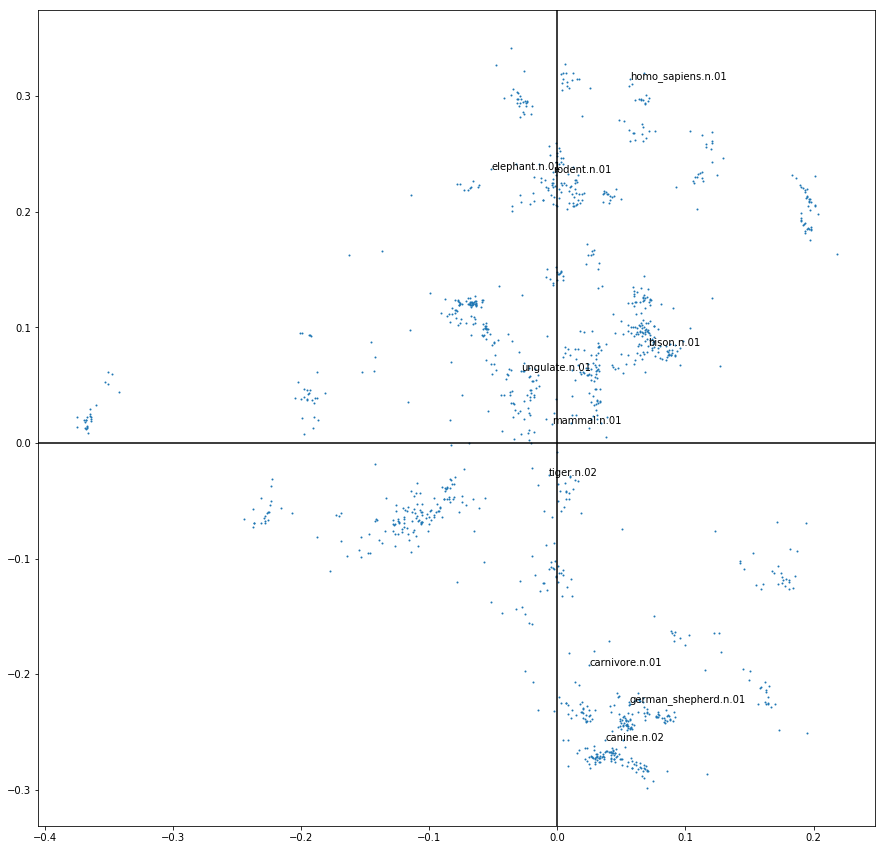

In [21]:
fig=plt.figure(figsize=(15,15))
names = []
positions_x = []
positions_y = []
for key in emb:
    names.append(key)
    positions_x.append(emb[key][0])
    positions_y.append(emb[key][1])

plt.scatter(positions_x,positions_y, s=1)
names_to_plot=[
    'mammal.n.01', 
    'carnivore.n.01', 
    'tiger.n.02', 
    'rodent.n.01', 
    'homo_sapiens.n.01', 
    'canine.n.02', 
    'german_shepherd.n.01',
    'ungulate.n.01',
    'elephant.n.01',
    'bison.n.01'
]
for name_to_plot in names_to_plot:
    j = names.index(name_to_plot)
    plt.text(positions_x[j], positions_y[j], names[j], fontsize=10)
    
# circle = plt.Circle((0, 0), 1, color='g',fill=False)

# plt.axis([-1,1,-1,1])
# ax=fig.add_subplot(1,1,1)
# ax.add_patch(circle)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

plt.show()

In [22]:
def evaluate_mean_rank_and_map(vocab, network, embeddings, max_n=None):
    """Evalue le mean rank et le MAP pour la reconstruction."""
    ranks = []
    avg_precision_scores = []
    for i, item in list(enumerate(vocab, start=0)):
        if item not in network or item == "mammal.n.01":
            continue
        item_relations = []
        temp = list(embeddings.keys())
        for relation in network[item]:
            item_relations.append(temp.index(relation))
            
        item_distances = all_distances_to(item, embeddings)
#         print("item", item)
        positive_relation_ranks, avg_precision = \
            get_positive_relation_ranks_and_avg_prec(item_distances, item_relations)
        ranks += positive_relation_ranks
        avg_precision_scores.append(avg_precision)
        if max_n is not None and i > max_n:
            break
    return np.mean(ranks), np.mean(avg_precision_scores)

def all_distances_to(item, embeddings):
    """Retourne une liste des distances d'un mot avec tous les autres"""
    all_distances=np.zeros(len(list(embeddings.keys())))
    
    for i, elem in list(enumerate(embeddings)):
        gamma = compute_gamma(embeddings[item], embeddings[elem])
        distance = poincare_dist(gamma)
        all_distances[i]=distance
    return all_distances
    
def get_positive_relation_ranks_and_avg_prec(all_distances, positive_relations):
    """
    Given a numpy array of all distances from an item and indices of its positive relations,
    compute ranks and Average Precision of positive relations.
    """
#     print("positive_relations", positive_relations)
    positive_relation_distances = all_distances[positive_relations]
    negative_relation_distances = np.ma.array(all_distances, mask=False)
#     value_max = np.nanmax(negative_relation_distances)
#     print('value_max', value_max)
    inds = np.where(np.isnan(negative_relation_distances))
#     if inds[0].shape[0]>0:
#         print('inds', inds)
#     negative_relation_distances[inds] = value_max

#     negative_relation_distances.mask[positive_relations] = True
    # Compute how many negative relation distances are less than each positive relation distance, plus 1 for rank
    ranks = (negative_relation_distances < positive_relation_distances[:, np.newaxis]).sum(axis=1) + 1
#     print("ranks :",ranks)
    map_ranks = np.sort(ranks) + np.arange(len(ranks))
    avg_precision = ((np.arange(1, len(map_ranks) + 1) / np.sort(map_ranks)).mean())
#     print("avg_precision", avg_precision)
    return list(ranks), avg_precision

In [23]:
mean_rank, map_ = evaluate_mean_rank_and_map(vocab, network, emb)

In [24]:
print('WordNet reconstruction')
print('Paramètres :')
print('Période de burn-in =', nb_burn_in)
print("Epochs =", num_epochs)
print("Learning rate =", lr)
print("Burn-in learning rate =", learning_rate_burn_in)
print("Dimension =", embedding_size)
print("un nombre de nodes négatives de", num_negs)
print("epsilon =", EPSILON)
print()
print("Résultats :")
print('Mean Rank =', mean_rank, "\nMAP =", map_)

WordNet reconstruction
Paramètres :
Période de burn-in = 10
Epochs = 1000
Learning rate = 0.01
Burn-in learning rate = 0.001
Dimension = 50
un nombre de nodes négatives de 20
epsilon = 1e-05

Résultats :
Mean Rank = 587.963619688 
MAP = 0.186560369645


## Prédiction

In [25]:
def get_root_and_leaf_nodes(data_file):
    """Return keys of root and leaf nodes from a file with transitive closure relations"""
    root_candidates = set()
    leaf_candidates = set()
    with open(data_file, 'rb') as f:
        for line in f:
            nodes = line.split()
            root_candidates.update(nodes)
            leaf_candidates.update(nodes)
    
    with open(data_file, 'rb') as f:
        for line in f:
            node_1, node_2 = line.split()
            if node_1 == node_2:
                continue
            leaf_candidates.discard(node_1)
            root_candidates.discard(node_2)
    
    return (leaf_candidates, root_candidates)

In [26]:
def train_test_split(data_file, test_ratio=0.1):
    train_filename = data_file + '.train'
    test_filename = data_file + '.test'
    if os.path.exists(train_filename) and os.path.exists(test_filename):
        return (train_filename, test_filename)
    root_nodes, leaf_nodes = get_root_and_leaf_nodes(data_file)
    test_line_candidates = []
    line_count = 0
    all_nodes = set()
    with open(data_file, 'rb') as f:
        for i, line in list(enumerate(f)):
            node_1, node_2 = line.split()
            all_nodes.update([node_1, node_2])
            if (
                    node_1 not in leaf_nodes
                    and node_2 not in leaf_nodes
                    and node_1 not in root_nodes
                    and node_2 not in root_nodes
                    and node_1 != node_2
                ):
                test_line_candidates.append(i)
            line_count += 1

    num_test_lines = int(test_ratio * line_count)
    test_line_indices = set(random.sample(test_line_candidates, num_test_lines))
    train_line_indices = set(l for l in range(line_count) if l not in test_line_indices)
    
    train_set_nodes = set()
    with open(data_file, 'rb') as f:
        train_file = open(train_filename, 'wb')
        test_file = open(test_filename, 'wb')
        for i, line in list(enumerate(f)):
            if i in train_line_indices:
                train_set_nodes.update(line.split())
                train_file.write(line)
            elif i in test_line_indices:
                test_file.write(line)
        train_file.close()
        test_file.close()
    assert len(train_set_nodes) == len(all_nodes), 'Not all nodes from dataset present in train set relations'
    return (train_filename, test_filename)

In [27]:
def evaluate_mean_rank_and_map_prediction(vocab, embeddings, items, relations, max_n=None):
    """Evaluate mean rank and MAP for link prediction."""
    ranks = []
    avg_precision_scores = []
    for i, item in list(enumerate(items, start=0)):
        if item not in relations['unknown'] or item == "mammal.n.01":
        #or item == "mammal.n.01":  # No positive relations to predict for this node
            continue
        unknown_relations = []
        for elem in list(relations['unknown'][item]):
            unknown_relations.append(vocab.index(elem))
        known_relations = []
        for elem in list(relations['known'][item]):
            known_relations.append(vocab.index(elem))
        
        item_distances = all_distances_to(item, embeddings)
        unknown_relation_ranks, avg_precision = \
            get_unknown_relation_ranks_and_avg_prec(item_distances, unknown_relations, known_relations)
        ranks += unknown_relation_ranks
        avg_precision_scores.append(avg_precision)
        if max_n is not None and i > max_n:
            break
    return np.mean(ranks), np.mean(avg_precision_scores)

In [28]:
def get_unknown_relation_ranks_and_avg_prec(all_distances, unknown_relations, known_relations):
    unknown_relation_distances = all_distances[unknown_relations]
    negative_relation_distances = np.ma.array(all_distances, mask=False)
    negative_relation_distances.mask[unknown_relations] = True
    negative_relation_distances.mask[known_relations] = True
    # Compute how many negative relation distances are less than each unknown relation distance, plus 1 for rank
    ranks = (negative_relation_distances < unknown_relation_distances[:, np.newaxis]).sum(axis=1) + 1
    map_ranks = np.sort(ranks) + np.arange(len(ranks))
    avg_precision = ((np.arange(1, len(map_ranks) + 1) / np.sort(map_ranks)).mean())
    return list(ranks), avg_precision

In [29]:
train_filename , test_filename = train_test_split('data/wordnet_mammal_hypernyms.tsv', test_ratio=0.1)

In [30]:
from collections import defaultdict

In [31]:
relations = {'known': defaultdict(set), 'unknown': defaultdict(set)}
data_files = {'known': train_filename, 'unknown': test_filename}

In [32]:
items = set()
for relation_type, data_file in data_files.items():
    with open(data_file, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for row in reader:
            relations[relation_type][row[0]].add(row[1])
            items.update([row[0], row[1]])

In [33]:
mean_rank, map_ = evaluate_mean_rank_and_map_prediction(vocab, emb, items, relations)

In [34]:
print('Link prediction')
print('Paramètres :')
print('Période de burn-in =', nb_burn_in)
print("Epochs =", num_epochs)
print("Learning rate =", lr)
print("Burn-in learning rate =", learning_rate_burn_in)
print("Dimension =", embedding_size)
print("un nombre de nodes négatives de", num_negs)
print("epsilon =", EPSILON)
print()
print("Résultats :")
print('Mean Rank =', mean_rank, "\nMAP =", map_)

Link prediction
Paramètres :
Période de burn-in = 10
Epochs = 1000
Learning rate = 0.01
Burn-in learning rate = 0.001
Dimension = 50
un nombre de nodes négatives de 20
epsilon = 1e-05

Résultats :
Mean Rank = 671.674870466 
MAP = 0.297683845515


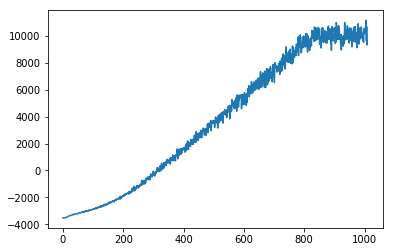

In [35]:
plt.plot(loss_stock)